# **Hausing Market Analysis**
By Krzysztof Budnik


#### **Project overview**: 
Project main goal is to run complex analysis to investigate key factors influencing the property prices in Gdańsk. <br />
<br />
The analysis document is split into several parts that include:
- **Data aquisition** (building custom web scraping solution to source high quality and real data)
- **Importing data** (transforming csv file into pandas dataframe)
- **Exploratory data analysis** (process of discovering the structure of data and its patterns)
- **Data Cleaning** (reformating the columns allowing mathematical operations, increasing readability and seting assumptions)
- **General Analysis** (discovering the distribution of property prices, influence of districts on price)
- **Qualitative Analysis** (how particular features impact the price, and how often they appear in offer listings)
- **Regression model** (evaluating how each feature impacts the price)




## **Importing modules**

In the very first step of the process I'm importing the necessary modules for analysis and data aqusition.  

In [120]:
# webscrapper 
import webscraper_functions as wf
from webscraper_elements import SearchCriteria, MarketType, get_url_list
from csv import writer

# data analysis
import pandas as pd 
import numpy as np

# data vizualizations
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## **Data aquisition**

I have designed dedicated web scraper programme to collect housing data directly from otodom.pl website. <br />
Programme has great amount of flexibility, allowing users to modify the search criteria <br />
and the size of downloaded datasets. Individual offer data is saved as record in CSV file. <br />
<br />
**Important Note**: Please do not run this cell unless you want to download the data. All necessary files are already provided.

In [80]:
# Choosing file name
file_name = "TEST.csv"

with open(file_name, 'w', encoding='utf8', newline='') as f:
    thewriter = writer(f)

    header = ["id", "title", "price", "city", "district", "street", 
                      "area", "rooms", "rent", "floor", "year", 
                      "balcony", "garage", "elevator", "furnishing", "extra_info",
                      "seller_type", "market", "ownership"]
    thewriter.writerow(header)
    
    # Defining search criteria
    search = SearchCriteria(
        market_type = MarketType.SECONDARY, 
        city = "gdansk", 
        limit = 72
    )
    
    # dataset size: (limit + 3) * num_of_pages
    # here: (72 + 3) * 10 = 750
    page_list = get_url_list(search, num_of_pages=10)
    
    for url in page_list:
        listings = wf.page_offer_list(url)
        for offer in listings:
            # main + location info
            main_info = wf.main_info(offer)
            location_info = wf.location_info(offer)

            # offer link + id 
            offer_url = wf.offer_url_generator(offer)
            offer_id = wf.offer_id_generator(offer_url)

            # accessing detailed offer data
            offer_soup = wf. offer_page_content(offer_url)
            detailed_info = wf.detailed_info(offer_soup)

            # all info
            all_info = wf.gather_offer_data(main_info, location_info, detailed_info, offer_id)

            # add data to csv
            thewriter.writerow(all_info)

## **Importing data**

In this step I'm converting CSV files into pandas dataframes. <br /> 
<br />
Both datasets store filtered data from Gdańsk. <br />
`primary` includes offers from primary market and `secondary` includes offers from secondary market  <br />
<br />
**Important Note**: Significant portion of the offers in `primary` didn't contain the information about price. <br />
Since this is one of the most important parameters, I have decided to exclude these records. <br />
<br />
`alldata` combines `dprimary` and `dsecondary`

In [3]:
primary = pd.read_csv("hdata_primary.csv")
primary = primary[primary.price != "Zapytaj o cenę"]

secondary = pd.read_csv("hdata_secondarymarket.csv")

alldata = pd.concat([primary, secondary]).reset_index()

# Checking the number of records in each dataset
print(f"primary: {len(primary)}",
      f"secondary: {len(secondary)}",
      f"alldata: {len(alldata)}",
      sep = "\n")

primary: 444
secondary: 750
alldata: 1194


## **Exploratory data analysis**

The main goal of EDA phase is to learn the structre of the data. Furthermore, this is also a great <br /> 
opportunity to discover any inconsistencies or missing valus across the dataset. <br /> 
<br /> 

At the beginning, I will investigate the first three rows of `alldata` dataset.

In [85]:
alldata.head(3)

,index,id,title,price,city,district,street,area,rooms,rent,floor,year,balcony,garage,elevator,furnishing,extra_info,seller_type,market,ownership
0,0,ID4g5qm,"Apartament 4 pokojowy, blisko morza",767 018 zł,Gdańsk,Letnica,NaN,"75,22 m²",4.0,zapytaj,2/6,NaN,zapytaj,zapytaj,nie,NaN,NaN,biuro nieruchomości,pierwotny,zapytaj
1,1,ID4gh74,Gdańsk Osowa Seleny nowe wygodne mieszkanie,749 000 zł,Gdańsk,Osowa,ul. Seleny,122 m²,6.0,zapytaj,1/1,NaN,taras,garaż/miejsce parkingowe,nie,NaN,"oddzielna kuchnia, dwupoziomowe",prywatny,pierwotny,zapytaj
2,3,ID4e9AW,5-pokojowe mieszkanie 91m2 + balkon Bezpośrednio,929 220 zł,Gdańsk,Ujeścisko-Łostowice,NaN,"91,1 m²",5.0,zapytaj,2/4,NaN,balkon,garaż/miejsce parkingowe,NaN,NaN,NaN,NaN,NaN,pełna własność


#### **Checking column data types** 

As we can see above, our data is likely to have a few limitations. We can already notice that the price is probably <br />
in a string format (currency is the part of the value). Moreover there are some missing in many columns. <br />
<br />
To ensure the data is consistent I'm going to check the data dypes and unique values <br />
for each relevant column (I will exclude columns such as `title` or `id` since they are not going to be a part of analysis)

In [4]:
alldata.drop(labels = ["index", "id", "title"], axis = 1, inplace =  True)
alldata.dtypes  

price           object
city            object
district        object
street          object
area            object
rooms           object
rent            object
floor           object
year           float64
balcony         object
garage          object
elevator        object
furnishing      object
extra_info      object
seller_type     object
market          object
ownership       object
dtype: object

#### **Exploring unique values**

Colums that are supposed to have numerical values  (`price`, `area`, `rooms`, `year`) are not formated as floats or strings. <br />
<br />
In the next code cell I'm going to check uniqe values for each column. Iterating the loop is an efficent method to <br />
quickly see all the values and catch errors 

In [124]:
unique_values_dict = {}

"""Building dictionary to store column names and coresponding unique values."""
for column in alldata.columns:
    unique_values_dict[column] = alldata[column].unique()
    
"""Printing the results."""
for key, item in unique_values_dict.items():
    print(key.upper())
    if len(item) > 10:
        print(item[:10])
    else: print(item)
    

PRICE
[ 767018.  749000.  929220.  669000.  825428.  750088.  450000.  923247.
 1028761.  649000.]
CITY
['Gdańsk']
DISTRICT
['Letnica' 'Osowa' 'Ujeścisko-Łostowice' 'Kokoszki' 'Siedlce' 'pomorskie'
 'Jasień' 'Wrzeszcz' 'Chełm' 'Młyniska']
STREET
[nan 'ul. Seleny' 'ul. Konrada Guderskiego' 'ul. Diany' 'ul. Warszawska'
 'Łostowice' 'ul. Kartuska 420B' 'Matemblewo' 'Jasińskiego'
 'ul. Starowiejska']
AREA
[ 75.22 122.    91.1   89.72  74.93  72.81  89.7   52.95  52.88  75.21]
ROOMS
[ 4.  6.  5.  3.  2.  1. 10.]
RENT
[498.89306931 480.         184.         250.         500.
   8.         300.         900.         800.         280.        ]
FLOOR
['2/6' '1/1' '2/4' 'parter/1' 'parter/4' '3/4' '1/3' '1/2' 'parter/2'
 '4/4']
YEAR
[  nan 2021. 1950. 1980. 1975. 2015. 2008. 2009. 2011. 2007.]
BALCONY
[0 1]
GARAGE
[0 1]
ELEVATOR
[0 1]
FURNISHING
[nan 'zmywarka, lodówka, meble, piekarnik, kuchenka'
 'zmywarka, lodówka, piekarnik, kuchenka, telewizor, pralka'
 'meble, piekarnik' 'zmywarka, meble'
 

#### **Conclusions** 

1. Numeric values should be formated as *floats* or *ints* not objects
2. Missing values (nan) are present in dataset. In case of some columns they will require further inspection.
3. Strange values such as *"zapytaj"* should be replaced in further steps of analysis. 
4. `Floor` column also has information about total floor number. If needed there is the possibility to split the column.

    <br />

## **Cleaning the data**
Part I of the analysis requires us to modify and clean the following columns: <br />

- `price` - convert to float64 (chage current strange format and remove currency "zł")
- `area` - convert to float64 (remove "m²")
- `rent` - convert to float64 (remove currency "zł"), missing values are going to be replaced with mean value
- `rooms` -convert to float64
- `city` - exclude any record that is not from Gdańsk (although data was filtered by city at data accuisition stage,  <br />
we can notice some strange values. Most likely these are the result of people inpuuting offer data in inappropriate fields)




#### **Cleaning functions**

Here, I design cleaning functions so in the next step I can apply them on dedicated columns. 

In [6]:
"""Cleaning: PRICE"""
def extract_price(value):
    value = value.replace(u"\xa0", u"") \
                 .replace(",", ".")               
    return float(value[:-2])

"""Cleeaning: AREA"""
def extract_area(value):
    if isinstance(value, str):
        value = value.replace(",", ".") \
                     .replace("m²", "") \
                     .strip() 
    return float(value)

"""Cleaning: RENT"""
def extract_rent(value):
    # I found one missing value formated as np.nan
    # Therefore I change it to "zapytaj" to match other missing values 
    if isinstance(value, float):
        value = "zapytaj"
    if value != "zapytaj":
        value = value.replace(" ", "") \
                     .replace(",", ".")
        value = float(value[:-2])
    return value

def replace_rent(value):
    # calculation of mean
    mean = alldata.rent[alldata.rent != "zapytaj"].mean()
    if value == "zapytaj":
        value = mean
    return value

"""Cleaning: ROOMS"""
def extract_rooms(value):
    if isinstance(value, str):
        try: 
            value = float(value.strip())
        except ValueError: 
            value = 10.0 
    return value

"""Cleaning: CITY"""
alldata = alldata[alldata.city == "Gdańsk"]

#### **Updating dataframe**

In [7]:
# PRICE
alldata.price = alldata.price.apply(extract_price)

#AREA
alldata.area = alldata.area.apply(extract_area)

#RENT
alldata.rent = alldata.rent.apply(extract_rent)
alldata.rent = alldata.rent.apply(replace_rent)

#ROOMS
alldata.rooms = alldata.rooms.apply(extract_rooms)

#### **Cleaning tests**

Now, all columns selected for modification are saved in appropriate format. <br />
Thanks to this change, it is possible to carry matematical opperations on these columns.

In [8]:
dtype_test = alldata[["price", "area", "rent", "rooms"]]
print(dtype_test.dtypes)
print(alldata.city.unique())

price    float64
area     float64
rent     float64
rooms    float64
dtype: object
['Gdańsk']


## **Analysis**

The ultimate goal of the analysis is to investigate how different factors affect the prices of properties. <br />

#### **Market overview**

At the begining, its important to check the general metrics. We can see below that there is quite substential <br />
difference between average and median price values. Mean value is larger then the median, as a result we can already suspect <br />
that the price distribution is right skewd.

In [9]:
summary = f"""General statistics:
Total number of properties: {len(alldata)}  
Avearge price: {alldata.price.mean():.2f}  
Median price {alldata.price.median()} 
Avearge rent: {alldata.rent.mean():.2f}  
"""
print(summary)

General statistics:
Total number of properties: 1188  
Avearge price: 716326.62  
Median price 598000.0 
Avearge rent: 498.89  



#### **Price distribution**

To illustrate this further let's look at the histogram. We can deffinitely confirm our initial assumpition <br />
about the distribution. The majority of offers listed fall between 300,000 and 1 millon price range. <br />
The assymetry is an obvios implication of very expensive proprties listed that are not that frequent.

**Important note**: In order to increae the readability of the chart, I only selected properties <br />
with price below 3,500,000 pln.

 

<AxesSubplot:xlabel='price', ylabel='Count'>

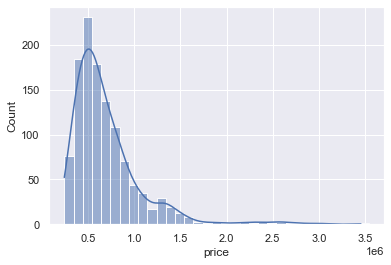

In [9]:
sns.set_theme(style="darkgrid")
sns.histplot(data=alldata[alldata.price < 3500000], 
             x="price", 
             binwidth=100000, 
             kde=True,
             )


Second vizualisation displays price distributions depending on the number of rooms. I have deselected properties <br />
with 6 or more rooms since there is too litte data about them. Thereby, these offers are insignificant for the analysis. <br />
<br />
As expected, when the numer of rooms increases, so does the mean value and distribution "moves to the right"

C:\Users\budcr\AppData\Local\Temp/ipykernel_20056/1445365037.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



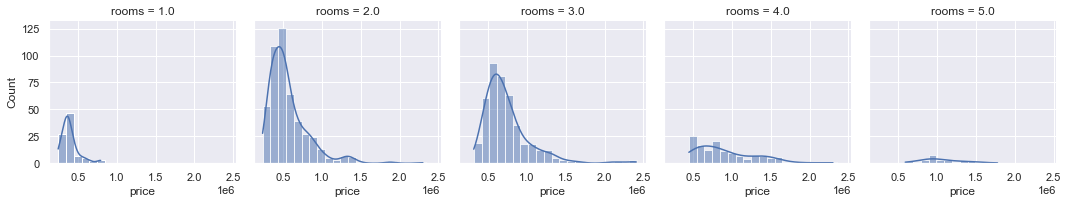

In [119]:
facet_grid_data = alldata[alldata.rooms<6][alldata.price < 2500000]

grid = sns.FacetGrid(facet_grid_data.reset_index(), col="rooms")
grid.map(sns.histplot, "price", binwidth=100000, kde=True)

#### **What are the most and least expensive districts?** 

In this part of the analysis, my goal is to discover how districts affect the price. <br /> 
<br />
I've created a function that calculates summary statistics for grupped data. Here, I group data by the distirict and <br />
measure the prices. I'm displaying only districts with 15 or more listings. This prevents showing areas with too little data or <br />
that were simply wrongly formated.

In [11]:
def summarise_stats(groupby: str, values_column: str, min_count=5):
    data_by_column = alldata.groupby(groupby)[values_column].agg([np.mean, np.median, min, max, len])
    data_by_column = data_by_column[data_by_column.len > min_count].round(2)
    return  data_by_column

stats_by_district = summarise_stats(groupby = "district", values_column = "price", min_count = 15)
stats_by_district = stats_by_district.sort_values(by = "mean", ascending = False)
stats_by_district

,mean,median,min,max,len
district,,,,,
Oliwa,1118733.48,960000.0,399000.0,2700000.0,48
Śródmieście,1025993.14,849000.0,285000.0,10900000.0,127
Brzeźno,931208.61,689000.0,349000.0,2850000.0,28
Wrzeszcz,892643.22,770000.0,399000.0,2550000.0,107
Zaspa,807772.86,740000.0,365000.0,1570000.0,35
Piecki-Migowo,750551.72,699000.0,447702.0,1475000.0,53
Przymorze,737296.05,669000.0,319000.0,3695000.0,80
Letnica,702358.23,676000.0,434000.0,1327000.0,58
pomorskie,680359.95,543974.0,241258.0,1444705.0,22


Bar chart illustrates the arranged oreder of most expensive districts in Gdańsk. Results are quite clear. <br />
On average the most expensive districts are 'Oliwa' and 'Śródmieście' with the cheapest being 'Orunia Górna-Gdańsk Południe' <br />
<br />
We can also notice, judging by the number of offers posted (`len` column) that districts 'Ujeścisko-Łostowice' and 'Jasień' <br />
are either quickly developing or people there are willing to change their place of living (they have the largest amounts <br />
of new offers: 185 and 158 respectively)

In [12]:
fig = px.bar(stats_by_district.reset_index(), x='district', y='mean', hover_data=['mean', 'median', "min", "max"])
fig.show()

#### **How number of rooms impacts the price?** 
Number of rooms also seems to be one of decesive factors influencing the price. We can see that the great majority  <br />
(almost 80%) of all offers posted on the website represent properties with 2 or 3 rooms. Flats with 5 rooms are the rarest <br />
and most expensive.


In [13]:
stats_by_num_rooms = summarise_stats(groupby = "rooms", values_column = "price", min_count = 15)
stats_by_num_rooms.sort_values(by = "mean")

,mean,median,min,max,len
rooms,,,,,
1.0,399227.42,369000.0,249200.0,794970.0,91
2.0,575595.26,499000.0,241258.0,2758000.0,481
3.0,773084.39,679000.0,320000.0,3456950.0,437
4.0,1025763.04,826714.0,449500.0,4400000.0,144
5.0,1268253.40,1028761.0,595000.0,4300000.0,31


Boxplot data gives us insights about how distribution of prices changes across properties with different number of rooms. <br />
The box with highest IQR is the one representing flats with 4 rooms. Hence, we can see that in this grup prices differ the most. <br />


C:\Users\budcr\AppData\Local\Temp/ipykernel_20056/119876913.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



<AxesSubplot:xlabel='rooms', ylabel='price'>

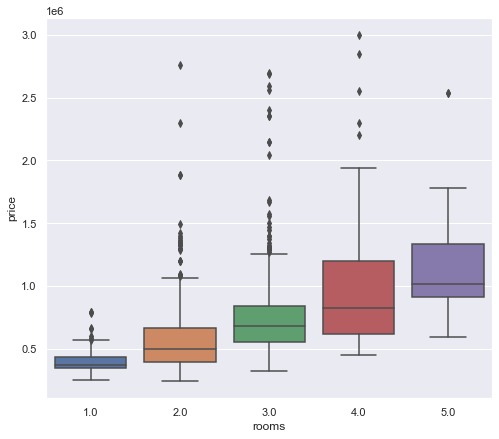

In [14]:
data_boxplot = alldata[alldata.rooms < 6][alldata.price < 3000000]

plt.figure(figsize=(8,7))
fig = sns.boxplot(data=data_boxplot.reset_index(), x="rooms", y="price")
fig

**Important note**: I have intenionally sliced the dataset to better ilustrate the distributions. <br />
I also included only properties with 5 rooms at maximum and with price lower then 3 million PLN. <br />
 Decreasing the amount of outliers raises the readability of the boxplots.

## **Analysis - Qualitative variables**

Amenities like the access to a garage, cellar or utility room may have real impact on the price. <br />
However, before the tests are viable, proper cleaning is required. Intrestingly, column `extra_info` contains data <br />
about both cellar and utility room in the property. Extraction of these details is going to be one of the next tasks.

#### **Cleaning qualitative variable columns**

Turning columns into boolean format:
- `seller_type` - is private (0/1)
- `market` - 0 - secondary, 1 - primary market
- `elevator`- has elevator (0/1)
- `balcony` - has balcony/garden (0/1)
- `garage` - has garage (0/1)
- `extra_info` - splitting into two new columns: `cellar` and `utility_room` (both in boolean format)

In [15]:
# Defining functions
def format_seller_type(value):
    if value == "prywatny": value = 1
    else: value = 0
    return value
    
def format_market(value): 
    if value == "wtorny": value = 0
    else: value = 1
    return value

def format_elevator(value):
    if value == "tak": value = 1
    else: value = 0
    return value
    
def format_balcony(value): 
    if isinstance(value, str):
        if "balkon" in value or "taras" in value: 
            value = 1
        else: value = 0
    else: value = 0
    return value

def format_garage(value): 
    if isinstance(value, str):
        if "garaż" in value: value = 1
        else: value = 0
    else: value = 0
    return value

def format_cellar(value): 
    if isinstance(value, str):
        if "piwnica" in value: value = 1
        else: value = 0
    else: value = 0
    return value

def format_utiliity_room(value): 
    if isinstance(value, str):
        if "pom. użytkowe" in value: 
            value = 1   
        else: value = 0
    else: value = 0
    return value

# Updating dataframe
alldata.seller_type = alldata.seller_type.apply(format_seller_type)
alldata.market = alldata.market.apply(format_market)
alldata.elevator = alldata.elevator.apply(format_elevator)
alldata.balcony = alldata.balcony.apply(format_balcony)
alldata.garage = alldata.garage.apply(format_garage)

# Creating cellar and utility_room columns
alldata.loc[:, "cellar"] = alldata["extra_info"].apply(format_cellar)
alldata.loc[:, "utility_room"] = alldata["extra_info"].apply(format_utiliity_room)

#### **Does garage, utility room or elevator increase the average cost of the property?**

To tackle this problem I've designed the function: `investigate_feature()` that takes column name as argument. <br /> 
Function's task is to divide the dataset into two groups (one group of offers has the feature (1) and the other doesn't <br />
have it (0)). Then it calculates average price of properites for each group and calculates the differance. 

In [142]:
def investigate_feature(column_name):
    f_yes = alldata[alldata[column_name] == 1]
    f_no = alldata[alldata[column_name] == 0]
    # calculating average values
    f_y_mean = f_yes.price.mean()
    f_n_mean = f_no.price.mean()
    
    message = f"""Comparison of average property prices for: {column_name.upper()} feature 
yes: {f_y_mean:.2f} zł, no: {f_n_mean:.2f} zł
Differance (yes - no): {f_y_mean - f_n_mean:.2f} zł"""
    return message

# Printing the results
qualitative_columns = ["garage", "cellar", "utility_room", 'elevator']
for col in qualitative_columns:
    feature_stats = investigate_feature(col)   
    print(feature_stats)
    print("\n")

Comparison of average property prices for: GARAGE feature 
yes: 761120.57 zł, no: 646655.15 zł
Differance (yes - no): 114465.43 zł


Comparison of average property prices for: CELLAR feature 
yes: 677132.75 zł, no: 741099.95 zł
Differance (yes - no): -63967.20 zł


Comparison of average property prices for: UTILITY_ROOM feature 
yes: 800182.18 zł, no: 679887.24 zł
Differance (yes - no): 120294.94 zł


Comparison of average property prices for: ELEVATOR feature 
yes: 772040.32 zł, no: 669619.16 zł
Differance (yes - no): 102421.16 zł




As we can see for `garage`, `utility_room` and `elevator` features, average prices differ by subsential margin from offers <br />
lacking these amenities. However, it is important to underline that we can't assume that one of these individual features <br />
independently increases the average property price by about 100,000 zł, as other factors may also play a significant role. <br />
<br />
We can on the other hand say that we see diferance in average prices given the feature is present or not. <br />
Intrestingly, it seems that properties with cellar are on avarage cheaper in comparison to those that don't have it. <br />
Again it only suggest that price of these properties is also influenced by other factors.

#### **How common are some of the qualitative features?**
In this part, I will investigate how frequelntly extra features like `garage` or `utility_room` appear on home listings. <br />

In [155]:
qualitative_columns = ["garage", "cellar", "utility_room", 'elevator', "balcony"]
count_values = []
   
for col in qualitative_columns:
    count = alldata[alldata[col] == 1]
    count_values.append(len(count))
    
px.bar(x=qualitative_columns, 
       y=count_values, 
       title="Counts of different features", 
       labels={
           "x": "Features",
           "y": "Counts"})



It turns out that the least frequent feature is the utility room with 361 offers out of 1187. <br /> 
On the contrary, garage and balcony features are present in the majority of the listings. <br />
<br />
(after hovering over a bar it is possible to check individual feature counts)

## **Analysis - Regression model**

**Multiple regression** model can be a great solution to estimate the impact of each feature on price. <br />
<br />
I have defined columns that will be part of the model in a list: `reg_columns`. <br />
Then I split the dataset into train and test sets, making it easy to check performace of the model in the future.


In [158]:
reg_columns = ['area', 'rooms', 'balcony', 
               'garage', 'elevator', 'cellar', 
               'utility_room', "seller_type"]

x = alldata[reg_columns]
y = alldata[['price']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2)

#### **Creating the model**
Creating the model and printing coeficient for each parameter. Given the results, we can notice that `area` <br /> 
is one of the most indicative features.

In [159]:
mlr = LinearRegression()

model = mlr.fit(x_train, y_train)
y_predict = mlr.predict(x_test)  
print(mlr.coef_)

[[ 14844.4781038  -77672.88662899 -36460.91088072  -6925.25957167
  157062.43244219 -63239.77644628  76355.76126272  86621.75616714]]


#### **Model performance**
Model predictions are measure by R squered parameter. The closer a score is to 1 the better. <br /> 
Our model did quite well however certainly there is a room for improvement. Probably if the data set was larger and <br />
the parameters were further optimized we would recive better results.   <br />

<br />
Nevertheless, it can approximate the influance of features decently to form general understanding.

In [161]:
print("Train score:")
print(mlr.score(x_train, y_train))

print("Test score:")
print(mlr.score(x_test, y_test))

Train score:
0.6580219485025699
Test score:
0.515194397727385


#### **Plotting actual vs predicted values**
On the chart, we are able to see that model give slightly overestimated predictions. 

Text(0.5, 1.0, 'actual vs predicted values')

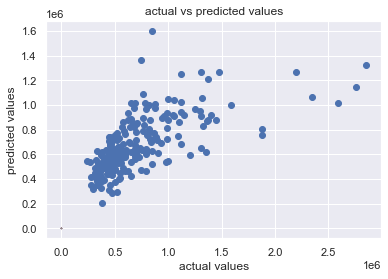

In [118]:
plt.scatter(x=y_test, y=y_predict)

plt.xlabel("actual values")
plt.ylabel("predicted values")
plt.title("actual vs predicted values")

## **Summary**